## General information

In this kernel I work with data from APTOS 2019 Blindness Detection competition

![](https://nei.nih.gov/sites/default/files/health-images/macula_dr.gif)

Our task is to detect blindeness. This problem feels quite important for me - I'm not blind or near it, but I have a bad eyesight, so I know that problems with eye are serious.

In this kernel I'll do a basic EDA and train a baseline pytorch model.

Important: in kernel-only competitions we can't use internet connections. So I use pretrained models from here: https://www.kaggle.com/bminixhofer/pytorch-pretrained-image-models

In [31]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import copy
import cv2
import albumentations
from albumentations import torch as AT

## Data overview

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
sample_submission = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')

In [3]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


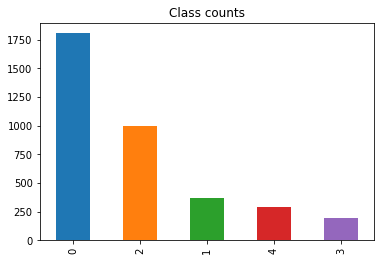

In [5]:
train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Class counts');

We have a slight disbalance in data.

In [ ]:
"""fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(old_train['level'].unique()):
    for i, (idx, row) in enumerate(old_train.loc[old_train['level'] == class_id].sample(10).iterrows()):
        ax = fig.add_subplot(5, 10, class_id * 10 + i + 1, xticks=[], yticks=[])
        im = Image.open(f'../input/diabetic-retinopathy-resized/resized_train/resized_train/{row["image"]}.jpeg')
        plt.imshow(im)
        ax.set_title(f'Label: {level}')"""

Personally I see little differences between images

## Data preparation

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [7]:
y, le = prepare_labels(train['diagnosis'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
class GlassDataset(Dataset):
    def __init__(self, df, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), y = None):
        self.df = df
        self.datatype = datatype
        if self.datatype == 'train':
            self.image_files_list = [f'../input/aptos2019-blindness-detection/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
            self.labels = y
        else:
            self.image_files_list = [f'../input/aptos2019-blindness-detection/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
            self.labels = np.zeros((df.shape[0], 5))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels[idx]
        if self.datatype == 'test':
            return image, label, img_name
        else:
            return image, label

In [9]:
dataset = GlassDataset(df=train, datatype='train', transform=data_transforms, y=y)

NameError: name 'data_transforms' is not defined

In [55]:

data_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_inc = albumentations.Compose([
    albumentations.Resize(229, 229),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test_inc = albumentations.Compose([
    albumentations.Resize(229, 229),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

dataset = GlassDataset(df=train, datatype='train', transform=data_transforms, y=y)
test_set = GlassDataset(df=test, datatype='test', transform=data_transforms_test)
dataset_inc = GlassDataset(df=train, datatype='train', transform=data_transforms_inc, y=y)
test_set_inc = GlassDataset(df=test, datatype='test', transform=data_transforms_test_inc)
tr, val = train_test_split(train.diagnosis, stratify=train.diagnosis, test_size=0.1)
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 16
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

train_loader_inc = torch.utils.data.DataLoader(dataset_inc, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader_inc = torch.utils.data.DataLoader(dataset_inc, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)
test_loader_inc = torch.utils.data.DataLoader(test_set_inc, batch_size=batch_size, num_workers=num_workers)


In [ ]:
#test_set = GlassDataset(df=test, datatype='test', transform=data_transforms_test)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)



In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
model_conv = torchvision.models.resnet101()
model_conv.load_state_dict(torch.load('../input/pytorch-pretrained-models/resnet101-5d3b4d8f.pth'))
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(2048, 5)

In [13]:
model_conv2 = torchvision.models.resnet50()
model_conv2.load_state_dict(torch.load('../input/pytorch-pretrained-models/resnet50-19c8e357.pth'))
num_ftrs2 = model_conv2.fc.in_features
model_conv2.fc = nn.Linear(2048, 5)

In [20]:
import os
os.listdir("../input/pretrained-pytorch-models")

['resnet50-19c8e357.pth',
 'squeezenet1_1-f364aa15.pth',
 'inception_v3_google-1a9a5a14.pth',
 'squeezenet1_0-a815701f.pth',
 'resnet18-5c106cde.pth',
 'densenet161-17b70270.pth']

In [17]:
model_conv3 = torchvision.models.vgg16()
model_conv3.load_state_dict(torch.load('../input/vgg16/vgg16.pth'))
model_conv3.classifier[6] = nn.Linear(4096,5)

In [19]:
model_conv4 = torchvision.models.densenet121()
model_conv4.load_state_dict(torch.load('../input/pytorch-pretrained-image-models/densenet121.pth'))
model_conv4.classifier = nn.Linear(1024, 5)

In [21]:
model_conv5 = torchvision.models.inception_v3()
model_conv5.load_state_dict(torch.load('../input/pretrained-pytorch-models/inception_v3_google-1a9a5a14.pth'))
model_conv5.AuxLogits.fc = nn.Linear(768, 5)
model_conv5.fc = nn.Linear(2048, 5)

In [56]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, n_epochs=15, attempt=1):
    valid_loss_min = np.Inf
    patience = 5
    # current number of epochs, where validation loss didn't increase
    p = 0
    # whether training should be stopped
    stop = False

    # number of epochs to train the model
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []
        train_auc = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target.float())
            train_loss.append(loss.item())

            a = target.data.cpu().numpy()
            b = output[:,-1].detach().cpu().numpy()
            # train_auc.append(roc_auc_score(a, b))
            loss.backward()
            optimizer.step()

        model_conv.eval()
        val_loss = []
        val_auc = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.cuda(), target.cuda()
            output = model_conv(data)

            loss = criterion(output, target.float())

            val_loss.append(loss.item()) 
            a = target.data.cpu().numpy()
            b = output[:,-1].detach().cpu().numpy()
            # val_auc.append(roc_auc_score(a, b))

        # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_conv.state_dict(), 'model_{}.pt'.format(attempt))
            valid_loss_min = valid_loss
            p = 0

        # check if validation loss didn't improve
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model_conv, model_conv

In [23]:


criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.99)
#scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, )

## Model training

In [ ]:
valid_loss_min = np.Inf
patience = 5
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# number of epochs to train the model
n_epochs = 20
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    train_auc = []

    for batch_i, (data, target) in enumerate(train_loader):

        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # train_auc.append(roc_auc_score(a, b))
        loss.backward()
        optimizer.step()
    
    model_conv.eval()
    val_loss = []
    val_auc = []
    for batch_i, (data, target) in enumerate(valid_loader):
        data, target = data.cuda(), target.cuda()
        output = model_conv(data)

        loss = criterion(output, target.float())

        val_loss.append(loss.item()) 
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # val_auc.append(roc_auc_score(a, b))

    # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
    
    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_conv.state_dict(), 'model_old_2.pt')
        valid_loss_min = valid_loss
        p = 0

    # check if validation loss didn't improve
    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break

In [29]:
dataloaders = {'train':train_loader, "val":valid_loader }
dataloaders_inc = {'train':train_loader_inc, "val":valid_loader_inc }

In [57]:
model_resnet101 = train_model(model_conv, train_loader, valid_loader, criterion = criterion, 
                              optimizer = optimizer, n_epochs=15)

Sun Aug 18 10:56:56 2019 Epoch: 1


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 15.90 GiB total capacity; 14.84 GiB already allocated; 9.88 MiB free; 376.55 MiB cached)

In [ ]:
model_resnet50 = train_model(model_conv2, train_loader, valid_loader, criterion = criterion, 
                              optimizer = optimizer, n_epochs=15)

In [ ]:
model_densenet121 = train_model(model_conv4, train_loader, valid_loader, criterion = criterion, 
                              optimizer = optimizer, n_epochs=15)

In [ ]:
model_vgg16 = train_model(model_conv3, train_loader, valid_loader, criterion = criterion, 
                              optimizer = optimizer, n_epochs=15)

In [ ]:
model_inception = train_model(model_conv5, train_loader_inc, valid_loader_inc, criterion = criterion, 
                              optimizer = optimizer, n_epochs=15)

## Predicting

In [27]:
def test_model(model, test_loader):
    sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
    model.eval()
    for (data, target, name) in test_loader:
        data = data.cuda()
        output = model(data)
        output = output.cpu().detach().numpy()
        for i, (e, n) in enumerate(list(zip(output, name))):
            sub.loc[sub['id_code'] == n.split('/')[-1].split('.')[0], 'diagnosis'] = le.inverse_transform([np.argmax(e)])
    return sub

In [ ]:
test_resnet101 = test_model(model_resnet101, test_loader)

In [ ]:
test_resnet50 = test_model(model_resnet50, test_loader)

In [ ]:
test_densenet121 = test_model(model_densenet121, test_loader)

In [ ]:
test_vgg16 = test_model(model_vgg16, test_loader)

In [ ]:
test_inception = test_model(model_inception, test_loader_inc)

In [ ]:
"""sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['id_code'] == n.split('/')[-1].split('.')[0], 'diagnosis'] = le.inverse_transform([np.argmax(e)])
        
sub.to_csv('submission.csv', index=False)"""

In [ ]:
sub.head()

In [ ]:
sub['diagnosis'].value_counts()